In [1]:
import random
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
from colorutils import Color

In [2]:
messages = pd.read_csv("texts/message_samples.csv")
options = pd.read_csv("texts/option_samples.csv")
names = pd.read_csv("texts/name_samples.csv")
messages.shape, options.shape, names.shape

((14, 5), (16, 3), (9, 2))

In [3]:
def create_textbox(w, h, hex, alpha=255):
    shape = [(0, 0), (w, h)]
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    img1.rectangle(shape, fill=hex, outline=None)
    img.putalpha(alpha)
    return img

## create textarea

In [18]:
class Margin:
    def __init__(self, top, right, bottom, left):
        self.top = top
        self.right = right
        self.bottom = bottom
        self.left = left

In [131]:
def get_height(font, c):
    # bbox = font.getbbox(c, anchor="la")  # bbox : left top right bottom
    # return bbox[3]-bbox[1]
    return font.getmetrics()[0] + font.getmetrics()[1]
    # return font.size


def create_textarea(
    text: str,
    w: int,
    h: int,
    margin: Margin,
    font,
    font_color,
    character_spacing, # 文字間隔
    line_spacing, # 行間
    add_ruby, # ルビを追加するかどうか
    ruby_font,
    ruby_font_color,
    ruby_character_spacing, # ルビの文字間隔
    ruby_line_spacing, # ルビとルビ対象文字列の間のスペース
):
    rendered_text = ""  # 描画済みのテキスト（改行ではみ出す場合は途中で返却する）

    # テキストはw, hの範囲に描画する
    # ルビのはみ出しはmarginまで許容し、それ以上はみ出すと描画されない
    text_img = Image.new(
        "RGBA",
        (
            w + margin.right + margin.left,
            h + margin.top + margin.bottom,
        ),
        (0, 0, 0, 0), # 背景色（透明）
    )
    text_img_draw = ImageDraw.Draw(text_img)

    # テキスト描画の開始位置
    x = margin.left
    y = margin.top

    if add_ruby:
        # ルビの描画位置を確保するために、ルビの高さをyに加算
        y += get_height(ruby_font, "あ") + ruby_line_spacing

    # テキストを1文字ずつ描画する際の一時情報
    max_height = -1 # 1行の最大高さ（文字により高さが異なるため、行ごとに高さを計算する必要がある）
    in_ruby_target = False

    ruby = ""
    ruby_target = ""
    ruby_target_x = {"left":-1, "right":-1}
    ruby_newline_checked = False

    # テキストを1文字ずつ描画
    # <ruby>漢字<rt>かんじ</rt></ruby> の形式を想定
    # 一つの<ruby>タグに複数の<rt>は含められない（rubyタグ自体を複数使って記述する必要がある）
    next_i = -1
    for i, c in enumerate(text):

        # タグの読み飛ばし
        if next_i > i:
            continue

        if c == "<":  # タグ記述の開始時
            tag = text[i : i + text[i:].index(">") + 1]  # <ruby>の場合、tag = "<ruby>"

            if tag == "<ruby>":
                ruby_newline_checked = False  # このループで文字描画前にルビ対象文字中に改行があるかを判定する
                ruby_target = text[i+6 : i+6 + text[i+6:].index("<")]  # ルビ対象文字列
                ruby_target_x["left"] = x  # ruby対象文字列の開始x
                in_ruby_target = True
                next_i = i+6  # タグが終わるまで読み飛ばす（次の文字はルビ対象文字列の1文字目）

            elif tag == "</ruby>":
                in_ruby_target = False
                next_i = i+7  # タグが終わるまで読み飛ばす
            
            elif tag == "<rt>":
                ruby = text[i+4 : i+4 + text[i+4:].index("<")]  # ルビ文字列
                ruby_target_x["right"] = x - character_spacing  # ruby対象文字列の右端のx座標
                next_i = i+4 + text[i+4:].index("<")  # ルビの最期まで読み飛ばす（次の文字は</rt>の<）
            
            elif tag == "</rt>":

                # ルビを一括で描画する
                ruby_target_width = ruby_target_x["right"] - ruby_target_x["left"]
                ruby_center_x = (ruby_target_x["left"] + ruby_target_x["right"]) / 2

                # ルビ対象文字列の幅と、ルビを普通に配置した時の幅を両方計算して比較する
                ruby_characters_width = sum([ruby_font.getlength(rc) for rc in ruby])
                ruby_calcled_width = ruby_characters_width + (
                    ruby_character_spacing * (len(ruby) + 1)
                )
                if ruby_target_width > ruby_calcled_width and len(ruby) > 1:
                    # ルビ対象文字列の幅が広い場合は、ruby_target_xの間に均等割り付け
                    _ruby_character_spacing = (
                        ruby_target_width - ruby_characters_width
                    ) / (len(ruby) + 1)
                    ruby_x = ruby_target_x["left"] + _ruby_character_spacing
                else:
                    # 幅が足りない場合（私（わたくし）など）は、ruby_center_x周りにruby_character_spacingで配置
                    ruby_x = ruby_center_x - ruby_calcled_width / 2
                    _ruby_character_spacing = ruby_character_spacing

                    if ruby_x < 0:
                        # 一文字目に長いrubyがある場合はみ出すことがある
                        raise ValueError(
                            f"Ruby overflowed from the left of the text area. {ruby_x}"
                        )

                # 高さ計算
                ruby_max_height = max([get_height(ruby_font, rc) for rc in ruby])
                ruby_y = y - (ruby_max_height + ruby_line_spacing)

                # ルビを1文字ずつ描画
                for rc in ruby:
                    text_img_draw.text(
                        (ruby_x, ruby_y), rc, fill=ruby_font_color, font=ruby_font
                    )
                    ruby_x += ruby_font.getlength(rc) + _ruby_character_spacing
                    if ruby_x - _ruby_character_spacing > w + margin.right:
                        # 右側にはみ出した場合は描画されないため、エラーを上げる
                        raise ValueError(
                            f"Ruby overflowed from the right of the text area. {ruby_x - _ruby_character_spacing} > {w + margins.right}"
                        )
                rendered_text = text[:i+1]

                # ルビ情報リセット
                ruby_target_x =  {"left":-1, "right":-1}
                ruby = ""
                ruby_target = ""
                next_i = i+5  # タグが終わるまで読み飛ばす

            else:
                raise ValueError(f"Invalid tag: {tag}")
            continue

        # 改行判定
        insert_new_line = False
        if in_ruby_target:
            if not ruby_newline_checked:
                # ルビ対象中は改行しない
                # ルビ対象文字の1文字目にルビ終了までの長さを先読みして改行判定
                insert_new_line = (
                    x
                    + sum(
                        [font.getlength(_c) + character_spacing for _c in ruby_target]
                    )
                    > w
                )
                if insert_new_line:
                    ruby_target_x["left"] = margin.left
                ruby_newline_checked = True
        else:
            insert_new_line = x + font.getlength(c) > w

        # 改行処理
        if insert_new_line:
            y += max_height + line_spacing
            if add_ruby:
                y += get_height(ruby_font, "あ") + ruby_line_spacing
            x = margin.left
            max_height = -1

            if y + get_height(font, c) > h + margin.top + margin.bottom:
                return text_img, rendered_text  # 改行までに描画した文字列を返す
                # raise ValueError(
                #     f"Height was insufficient at new line. {y + get_height(font, c)} > {h + margin.top + margin.bottom}"
                # )

        # 改行時の行高さをその行の文字の最大高さで計算
        max_height = max(max_height, get_height(font, c))


        # draw character
        text_img_draw.text((x, y), c, fill=font_color, font=font)  # , anchor="lt")
        rendered_text = text[:i+1]

        x += font.getlength(c) + character_spacing

    return text_img, text

## settings

In [138]:
W, H = 1920, 1080
# キャラクターの位置
fg_tl = (200, 100)

# msgbox
msgbox_tl = (35, 800)
msgbox_br = (1880, 1055)
# msgbox_hex = Color(hsv=(180, 1, .5)).hex
msgbox_hex = Color(hsv=(223, .77, .38)).hex
msgbox_alpha = 160

# msg text area
msg_margin = Margin(top=30, right=50, left=30, bottom=50)
msg_line_spacing = 0
msg_character_spacing = 5
msg_font_size = 48
msg_ruby_font_size = 20
msg_ruby_line_spacing = -10
msg_ruby_character_spacing = 1
msg_font_color = tuple([int(c) for c in Color(hsv=(0, 0, 1)).rgb])
msg_font = ImageFont.truetype(font="./fonts/NotoSansJP-Regular.otf", size=msg_font_size)
msg_ruby_font = ImageFont.truetype(font="./fonts/NotoSansJP-Bold.otf", size=msg_ruby_font_size)

# namebox
namebox_tl = (15, 735)
namebox_br = (600, 820)
namebox_hex = Color(hsv=(220, .6, .3)).hex
namebox_alpha = 180

# name text area
name_margin = Margin(top=2, right=0, left=30, bottom=2)
name_line_spacing = 0
name_character_spacing = 10
name_font_size = 44
name_ruby_font_size = 16
name_ruby_line_spacing = -10
name_ruby_character_spacing = 0
name_font_color = tuple([int(c) for c in Color(hsv=(0, 0, 1)).rgb])
name_font = ImageFont.truetype(font="./fonts/NotoSansJP-Regular.otf", size=name_font_size)
name_ruby_font = ImageFont.truetype(font="./fonts/NotoSansJP-Bold.otf", size=name_ruby_font_size)

## trial

In [125]:
# name_text = "<ruby>桜<rt>さくら</rt></ruby>あああああああああああああああ"
# text = "<ruby>私<rt>わたくし</rt></ruby>ああああああああああああああああああ"

In [126]:
text = messages.sample(1)["text_ruby_hiragana"].values[0]
name_text, name_ruby = names.sample(1)[["name", "ruby"]].values[0]
if type(name_ruby) == str:
    name_text = f"<ruby>{name_text}<rt>{name_ruby}</rt></ruby>"
text, name_text

('<ruby>精麦<rt>せいばく</rt></ruby>も出来るし、<ruby>精酒<rt>せいしゅ</rt></ruby>にもできる。そしてこのお<ruby>酒<rt>さけ</rt></ruby>は<ruby>魔法酒<rt>まほうしゅ</rt></ruby>の類いでは<ruby>最高品質<rt>さいこうひんしつ</rt></ruby>の<ruby>物<rt>もの</rt></ruby>だ',
 '<ruby>草柳<rt>くさやなぎ</rt></ruby>')

<ruby>精麦<rt>せいばく</rt></ruby>も出来るし、<ruby>精酒<rt>せいしゅ</rt></ruby>にもできる。そしてこのお<ruby>酒<rt>さけ</rt></ruby>は<ruby>魔法酒<rt>まほうしゅ</rt></ruby>の類いでは<ruby>最高品質<rt>さいこうひんしつ</rt></ruby>の<ruby>物<rt>もの</rt></ruby>だ
<ruby>精麦<rt>せいばく</rt></ruby>も出来るし、<ruby>精酒<rt>せいしゅ</rt></ruby>にもできる。そしてこのお<ruby>酒<rt>さけ</rt></ruby>は<ruby>魔法酒<rt>まほうしゅ</rt></ruby>の類いでは<ruby>最高品質<rt>さいこうひんしつ</rt></ruby>の<ruby>物<rt>もの</rt></ruby>だ
<ruby>草柳<rt>くさやなぎ</rt></ruby>
<ruby>草柳<rt>くさやなぎ</rt></ruby>


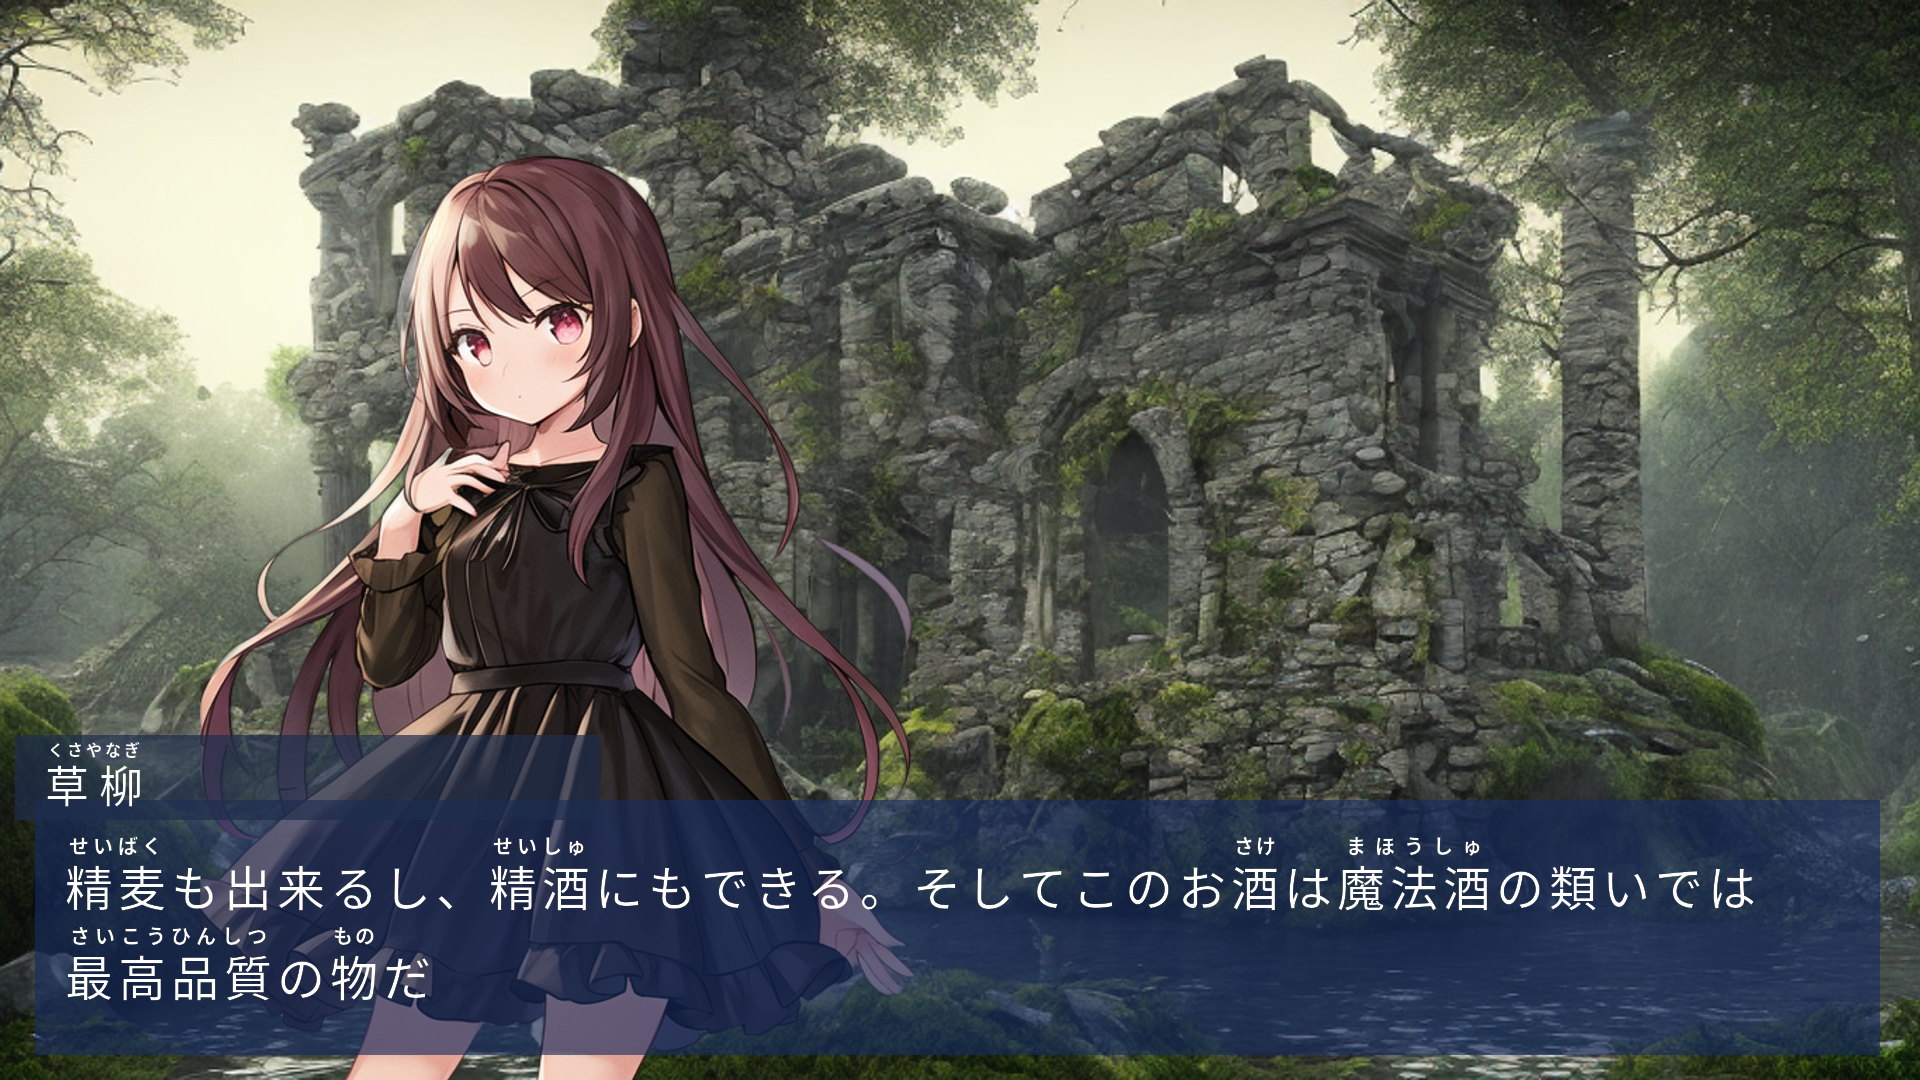

In [139]:
# bg
bg_path = "./bgimages/3.png"
bg = Image.open(bg_path).resize((W, H))

# character
fg_path = "./fgimages/2.png"
fg = Image.open(fg_path)
fg = fg.resize((int(fg.width*(H/fg.height)), H))

# message
msgbox_size = (msgbox_br[0] - msgbox_tl[0], msgbox_br[1] - msgbox_tl[1])
msgbox = create_textbox(
    w=msgbox_size[0],
    h=msgbox_size[1],
    hex=msgbox_hex,
    alpha=msgbox_alpha
    )

print(text)
add_ruby = "<ruby>" in text
# try:
msg_text_img, rendered_msg = create_textarea(
    text,
    w=msgbox_size[0]-(msg_margin.left+msg_margin.right),
    h=msgbox_size[1]-(msg_margin.top+msg_margin.bottom),
    margin=msg_margin,
    font=msg_font, font_color=msg_font_color,
    character_spacing=msg_character_spacing, line_spacing=msg_line_spacing,
    add_ruby=add_ruby,
    ruby_font=msg_ruby_font, ruby_font_color=msg_font_color,
    ruby_character_spacing=msg_ruby_character_spacing, ruby_line_spacing=msg_ruby_line_spacing
    )
# except Exception as e:
#     print(e)
print(rendered_msg)

msgbox.paste(msg_text_img, (0, 0), msg_text_img)

# name
namebox_size = (namebox_br[0] - namebox_tl[0], namebox_br[1] - namebox_tl[1])
namebox = create_textbox(
    w=namebox_size[0],
    h=namebox_size[1],
    hex=namebox_hex,
    alpha=namebox_alpha
    )

print(name_text)
# try:
add_ruby = "<ruby>" in name_text
name_text_img, rendered_name = create_textarea(
    name_text,
    w=namebox_size[0]-(name_margin.left+name_margin.right),
    h=namebox_size[1]-(name_margin.top+name_margin.bottom),
    margin=name_margin,
    font=name_font, font_color=name_font_color,
    character_spacing=name_character_spacing, line_spacing=name_line_spacing,
    add_ruby=add_ruby,
    ruby_font=name_ruby_font, ruby_font_color=name_font_color,
    ruby_character_spacing=name_ruby_character_spacing, ruby_line_spacing=name_ruby_line_spacing
    )
# except Exception as e:
#     print(e)
print(rendered_name)
namebox.paste(name_text_img, (0, 0), name_text_img)

# paste
img = bg.copy()
img.paste(fg, fg_tl, fg)
img.paste(msgbox, msgbox_tl, msgbox)
img.paste(namebox, namebox_tl, namebox)
img